In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Conv2D, Lambda, MaxPooling2D # convolution layers
from keras.layers import Dense, Dropout, Flatten # core layers

from keras.layers.normalization import BatchNormalization

from keras.preprocessing.image import ImageDataGenerator

from keras.utils.np_utils import to_categorical

#from keras.datasets import mnist

Using TensorFlow backend.


In [2]:
import os
print(os.listdir('../input'))

['sample_submission.csv', 'train.csv', 'test.csv']


In [3]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
sub = pd.read_csv('../input/sample_submission.csv')
print("Data are Ready!!")

Data are Ready!!


In [4]:
print(f"Training data size is {train.shape}\nTesting data size is {test.shape}")

Training data size is (42000, 785)
Testing data size is (28000, 784)


In [5]:
X = train.drop(['label'], 1).values
y = train['label'].values

test_x = test.values

In [6]:
X = X / 255.0
test_x = test_x / 255.0

In [7]:
# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
# canal = 1 => For gray scale
X = X.reshape(-1,28,28,1)
test_x = test_x.reshape(-1,28,28,1)

In [8]:
# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
y = to_categorical(y)

print(f"Label size {y.shape}")

Label size (42000, 10)


In [9]:
# Split the train and the validation set for the fitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

In [10]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((37800, 28, 28, 1), (4200, 28, 28, 1), (37800, 10), (4200, 10))

In [12]:
mean = np.mean(X_train)
std = np.std(X_train)

def standardize(x):
    return (x-mean)/std

In [13]:
epochs = 50
batch_size = 64

In [14]:
model=Sequential()

#model.add(Lambda(standardize,input_shape=(28,28,1)))    
model.add(Conv2D(filters=64, kernel_size = (3,3), activation="relu", input_shape=(28,28,1)))
model.add(Conv2D(filters=64, kernel_size = (3,3), activation="relu"))

model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size = (3,3), activation="relu"))
model.add(Conv2D(filters=128, kernel_size = (3,3), activation="relu"))

model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())    
model.add(Conv2D(filters=256, kernel_size = (3,3), activation="relu"))
    
model.add(MaxPooling2D(pool_size=(2,2)))
    
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(512,activation="relu"))
    
model.add(Dense(10,activation="softmax"))
    
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [15]:
# With data augmentation to prevent overfitting

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


#datagen.fit(X_train)
train_gen = datagen.flow(X_train, y_train, batch_size=batch_size)
test_gen = datagen.flow(X_test, y_test, batch_size=batch_size)

In [16]:
# This make accuarcy 0.998
#model.fit(X, y, batch_size=batch_size, validation_split=0.2, epochs=10)

In [17]:
# Fit the model
history = model.fit_generator(train_gen, 
                              epochs = epochs, 
                              steps_per_epoch = X_train.shape[0] // batch_size,
                              validation_data = test_gen,
                              validation_steps = X_test.shape[0] // batch_size)

Epoch 1/50
590/590 [==============================] - 196s 332ms/step - loss: 0.1509 - acc: 0.9520 - val_loss: 0.0720 - val_acc: 0.9786
Epoch 2/50
590/590 [==============================] - 194s 328ms/step - loss: 0.0686 - acc: 0.9786 - val_loss: 0.0909 - val_acc: 0.9717
Epoch 3/50
590/590 [==============================] - 195s 330ms/step - loss: 0.0551 - acc: 0.9836 - val_loss: 0.0456 - val_acc: 0.9867
Epoch 4/50
590/590 [==============================] - 195s 331ms/step - loss: 0.0484 - acc: 0.9856 - val_loss: 0.0484 - val_acc: 0.9845
Epoch 5/50
590/590 [==============================] - 194s 329ms/step - loss: 0.0434 - acc: 0.9870 - val_loss: 0.0454 - val_acc: 0.9855
Epoch 6/50
590/590 [==============================] - 196s 332ms/step - loss: 0.0380 - acc: 0.9881 - val_loss: 0.0573 - val_acc: 0.9845
Epoch 7/50
590/590 [==============================] - 195s 330ms/step - loss: 0.0377 - acc: 0.9891 - val_loss: 0.0654 - val_acc: 0.9809
Epoch 8/50
590/590 [============================

In [18]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

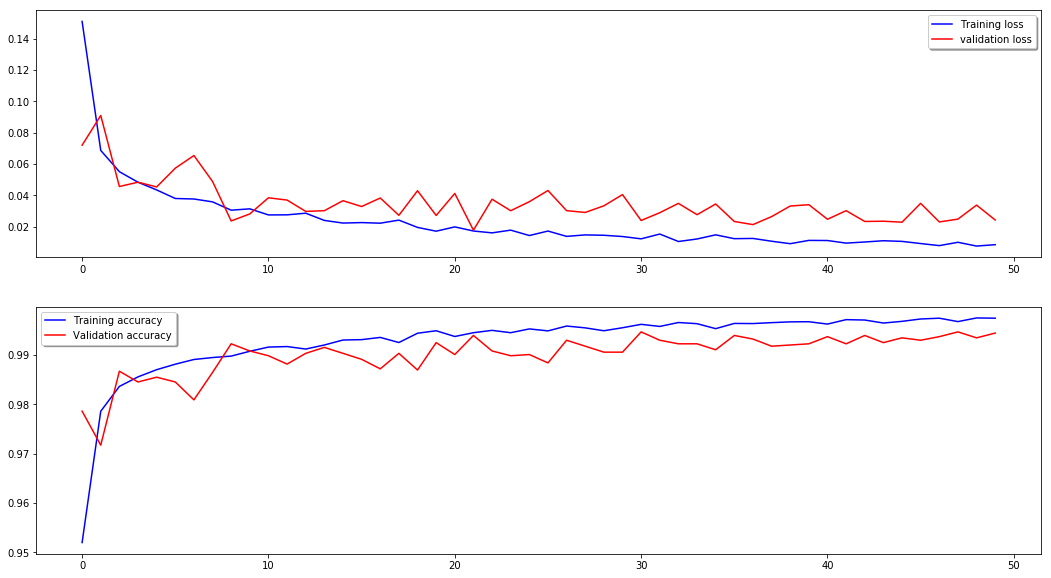

In [19]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1, figsize=(18, 10))
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

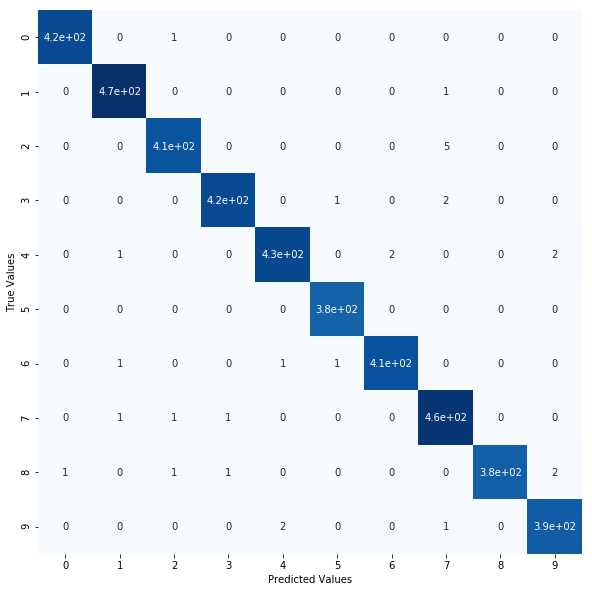

In [20]:
fig = plt.figure(figsize=(10, 10)) # Set Figure

y_pred = model.predict(X_test) # Predict encoded label as 2 => [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]

Y_pred = np.argmax(y_pred, 1) # Decode Predicted labels
Y_test = np.argmax(y_test, 1) # Decode labels

mat = confusion_matrix(Y_test, Y_pred) # Confusion matrix

# Plot Confusion matrix
sns.heatmap(mat.T, square=True, annot=True, cbar=False, cmap=plt.cm.Blues)
plt.xlabel('Predicted Values')
plt.ylabel('True Values');
plt.show();

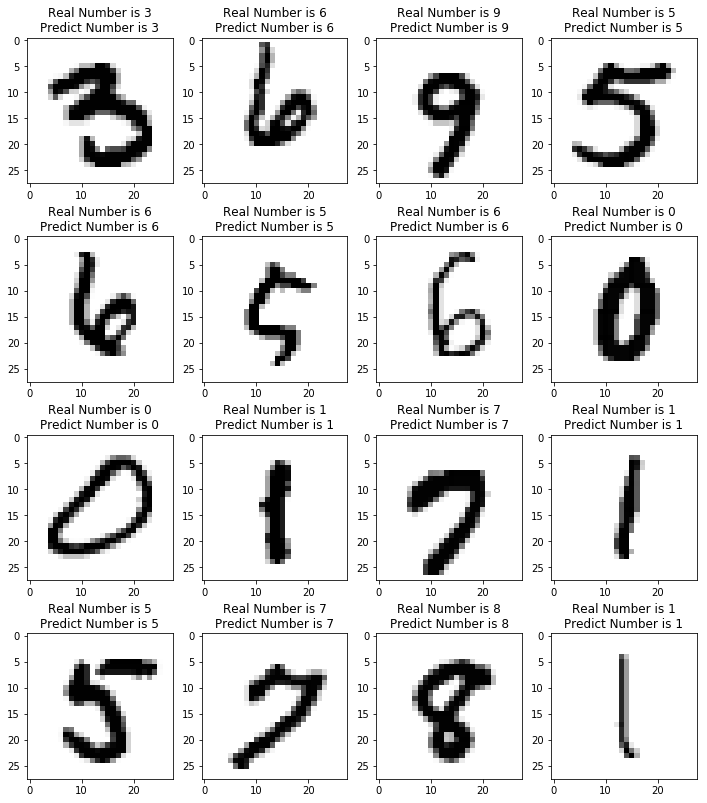

In [21]:
y_pred = model.predict(X_test)
X_test__ = X_test.reshape(X_test.shape[0], 28, 28)

fig, axis = plt.subplots(4, 4, figsize=(12, 14))
for i, ax in enumerate(axis.flat):
    ax.imshow(X_test__[i], cmap='binary')
    ax.set(title = f"Real Number is {y_test[i].argmax()}\nPredict Number is {y_pred[i].argmax()}");

In [22]:
pred = model.predict_classes(test_x, verbose=1)

28000/28000 [==============================] - 43s 2ms/step


In [23]:
sub['Label'] = pred
sub.to_csv("CNN_keras_sub.csv", index=False)
sub.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3
